In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import warnings
import json
import os

import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2
from sklearn.metrics import log_loss
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar

# Set up plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


In [3]:
# Load and explore the kidney stone data
print("Loading kidney stone treatment data...")
df = pd.read_csv('data/kidney_stone_data.csv')

# Display basic information about the dataset
print(f"\nDataset Shape: {df.shape}")
print(f"Number of patients: {len(df)}")

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

print("\nFirst 10 rows:")
display(df.head(10))

print(f"\nData Types:")
print(df.dtypes)

print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nUnique Values per Column:")
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"  {col}: {unique_vals} (n={len(unique_vals)})")

print(f"\nBasic Statistics:")
display(df.describe(include='all'))

Loading kidney stone treatment data...

Dataset Shape: (700, 3)
Number of patients: 700

DATASET OVERVIEW

First 10 rows:


,treatment,stone_size,success
0,B,large,1
1,A,large,1
2,A,large,0
3,A,large,1
4,A,large,1
5,B,large,1
6,A,small,1
7,B,large,1
8,B,small,1
9,A,large,1



Data Types:
treatment     object
stone_size    object
success        int64
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   700 non-null    object
 1   stone_size  700 non-null    object
 2   success     700 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 16.5+ KB
None

Missing Values:
treatment     0
stone_size    0
success       0
dtype: int64

Unique Values per Column:
  treatment: ['B' 'A'] (n=2)
  stone_size: ['large' 'small'] (n=2)
  success: [1 0] (n=2)

Basic Statistics:


,treatment,stone_size,success
count,700,700,700.000000
unique,2,2,NaN
top,B,small,NaN
freq,350,357,NaN
mean,NaN,NaN,0.802857
std,NaN,NaN,0.398126
min,NaN,NaN,0.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,1.000000


In [4]:
# Display distribution of variables
print("="*60)
print("VARIABLE DISTRIBUTIONS")
print("="*60)

# Treatment distribution
print(f"\nTreatment Distribution:")
treatment_counts = df['treatment'].value_counts()
print(treatment_counts)
print(f"Treatment A: {treatment_counts['A']} patients ({treatment_counts['A']/len(df)*100:.1f}%)")
print(f"Treatment B: {treatment_counts['B']} patients ({treatment_counts['B']/len(df)*100:.1f}%)")

# Stone size distribution
print(f"\nStone Size Distribution:")
stone_counts = df['stone_size'].value_counts()
print(stone_counts)
print(f"Small stones: {stone_counts['small']} patients ({stone_counts['small']/len(df)*100:.1f}%)")
print(f"Large stones: {stone_counts['large']} patients ({stone_counts['large']/len(df)*100:.1f}%)")

# Success rate distribution
print(f"\nOverall Success Rate:")
success_counts = df['success'].value_counts()
print(success_counts)
print(f"Successful: {success_counts[1]} patients ({success_counts[1]/len(df)*100:.1f}%)")
print(f"Unsuccessful: {success_counts[0]} patients ({success_counts[0]/len(df)*100:.1f}%)")

# Cross-tabulation
print(f"\nCross-tabulation of Treatment and Stone Size:")
crosstab = pd.crosstab(df['treatment'], df['stone_size'], margins=True)
print(crosstab)

print(f"\nCross-tabulation of Treatment and Success:")
crosstab_success = pd.crosstab(df['treatment'], df['success'], margins=True)
print(crosstab_success)

# Validate data integrity
print("\n" + "="*60)
print("DATA VALIDATION")
print("="*60)

# Check for unexpected values
valid_treatments = {'A', 'B'}
valid_stone_sizes = {'small', 'large'}
valid_success = {0, 1}

invalid_treatments = set(df['treatment'].unique()) - valid_treatments
invalid_stone_sizes = set(df['stone_size'].unique()) - valid_stone_sizes
invalid_success = set(df['success'].unique()) - valid_success

if invalid_treatments or invalid_stone_sizes or invalid_success:
    print("⚠ WARNING: Invalid values found:")
    if invalid_treatments:
        print(f"  Invalid treatments: {invalid_treatments}")
    if invalid_stone_sizes:
        print(f"  Invalid stone sizes: {invalid_stone_sizes}")
    if invalid_success:
        print(f"  Invalid success values: {invalid_success}")
else:
    print("✓ All data values are valid")
    
print(f"✓ No missing values found")
print(f"✓ Dataset contains expected 700 patients")
print(f"✓ Data structure is correct for analysis")

VARIABLE DISTRIBUTIONS

Treatment Distribution:
treatment
B    350
A    350
Name: count, dtype: int64
Treatment A: 350 patients (50.0%)
Treatment B: 350 patients (50.0%)

Stone Size Distribution:
stone_size
small    357
large    343
Name: count, dtype: int64
Small stones: 357 patients (51.0%)
Large stones: 343 patients (49.0%)

Overall Success Rate:
success
1    562
0    138
Name: count, dtype: int64
Successful: 562 patients (80.3%)
Unsuccessful: 138 patients (19.7%)

Cross-tabulation of Treatment and Stone Size:
stone_size  large  small  All
treatment                    
A             263     87  350
B              80    270  350
All           343    357  700

Cross-tabulation of Treatment and Success:
success      0    1  All
treatment               
A           77  273  350
B           61  289  350
All        138  562  700

DATA VALIDATION
✓ All data values are valid
✓ No missing values found
✓ Dataset contains expected 700 patients
✓ Data structure is correct for analysis


In [5]:
# Save the data in JSON format for downstream processes
print("Saving input data in JSON format...")

# Convert the DataFrame to JSON format
json_data = df.to_json(orient='records', indent=2)

# Save to output directory
with open('/home/user/output/kidney_stone_data.json', 'w') as f:
    f.write(json_data)

# Also save a sample of the data structure for reference
data_sample = {
    "data_description": "Kidney Stone Treatment Dataset",
    "total_patients": len(df),
    "columns": {
        "treatment": "Treatment type (A or B)",
        "stone_size": "Stone size (small or large)", 
        "success": "Treatment outcome (1=successful, 0=unsuccessful)"
    },
    "sample_records": df.head(10).to_dict('records'),
    "summary_statistics": {
        "treatment_distribution": df['treatment'].value_counts().to_dict(),
        "stone_size_distribution": df['stone_size'].value_counts().to_dict(),
        "overall_success_rate": f"{df['success'].mean():.3f}"
    }
}

with open('data/data_summary.json', 'w') as f:
    json.dump(data_sample, f, indent=2)

print("✓ Input data saved in JSON format:")
print("  - kidney_stone_data.json: Full dataset")
print("  - data_summary.json: Data description and sample")

print(f"\nJSON Sample (first 3 records):")
sample_records = df.head(3).to_dict('records')
for i, record in enumerate(sample_records, 1):
    print(f"Record {i}: {record}")

Saving input data in JSON format...
✓ Input data saved in JSON format:
  - kidney_stone_data.json: Full dataset
  - data_summary.json: Data description and sample

JSON Sample (first 3 records):
Record 1: {'treatment': 'B', 'stone_size': 'large', 'success': 1}
Record 2: {'treatment': 'A', 'stone_size': 'large', 'success': 1}
Record 3: {'treatment': 'A', 'stone_size': 'large', 'success': 0}


In [6]:
print("="*80)
print("SIMPSON'S PARADOX ANALYSIS")
print("="*80)

# Calculate overall success rates by treatment (this will show the paradox)
print("\n1. OVERALL SUCCESS RATES (Aggregated Analysis)")
print("-" * 50)

overall_success = df.groupby('treatment')['success'].agg(['count', 'sum', 'mean']).round(4)
overall_success.columns = ['Total_Patients', 'Successes', 'Success_Rate']
overall_success['Success_Percentage'] = (overall_success['Success_Rate'] * 100).round(1)

print(overall_success)

# Calculate the difference
treatment_a_rate = overall_success.loc['A', 'Success_Rate']
treatment_b_rate = overall_success.loc['B', 'Success_Rate']
overall_difference = treatment_b_rate - treatment_a_rate

print(f"\nOverall Treatment Comparison:")
print(f"Treatment A success rate: {treatment_a_rate:.1%} ({overall_success.loc['A', 'Successes']}/{overall_success.loc['A', 'Total_Patients']})")
print(f"Treatment B success rate: {treatment_b_rate:.1%} ({overall_success.loc['B', 'Successes']}/{overall_success.loc['B', 'Total_Patients']})")
print(f"Difference (B - A): {overall_difference:+.1%}")

if treatment_b_rate > treatment_a_rate:
    print("→ Overall conclusion: Treatment B appears BETTER")
else:
    print("→ Overall conclusion: Treatment A appears BETTER")

# Now calculate success rates within each stone size subgroup
print(f"\n\n2. SUCCESS RATES BY STONE SIZE SUBGROUPS")
print("-" * 50)

# Small stones
small_stones = df[df['stone_size'] == 'small']
small_success = small_stones.groupby('treatment')['success'].agg(['count', 'sum', 'mean']).round(4)
small_success.columns = ['Total_Patients', 'Successes', 'Success_Rate']
small_success['Success_Percentage'] = (small_success['Success_Rate'] * 100).round(1)

print("SMALL STONES:")
print(small_success)

small_a_rate = small_success.loc['A', 'Success_Rate']
small_b_rate = small_success.loc['B', 'Success_Rate']
small_difference = small_a_rate - small_b_rate

print(f"\nSmall stones comparison:")
print(f"Treatment A: {small_a_rate:.1%} ({small_success.loc['A', 'Successes']}/{small_success.loc['A', 'Total_Patients']})")
print(f"Treatment B: {small_b_rate:.1%} ({small_success.loc['B', 'Successes']}/{small_success.loc['B', 'Total_Patients']})")
print(f"Difference (A - B): {small_difference:+.1%}")

if small_a_rate > small_b_rate:
    print("→ For small stones: Treatment A is BETTER")
else:
    print("→ For small stones: Treatment B is BETTER")

SIMPSON'S PARADOX ANALYSIS

1. OVERALL SUCCESS RATES (Aggregated Analysis)
--------------------------------------------------
           Total_Patients  Successes  Success_Rate  Success_Percentage
treatment                                                             
A                     350        273        0.7800                78.0
B                     350        289        0.8257                82.6

Overall Treatment Comparison:
Treatment A success rate: 78.0% (273/350)
Treatment B success rate: 82.6% (289/350)
Difference (B - A): +4.6%
→ Overall conclusion: Treatment B appears BETTER


2. SUCCESS RATES BY STONE SIZE SUBGROUPS
--------------------------------------------------
SMALL STONES:
           Total_Patients  Successes  Success_Rate  Success_Percentage
treatment                                                             
A                      87         81        0.9310                93.1
B                     270        234        0.8667                86.7

Small s

In [7]:
# Large stones
large_stones = df[df['stone_size'] == 'large']
large_success = large_stones.groupby('treatment')['success'].agg(['count', 'sum', 'mean']).round(4)
large_success.columns = ['Total_Patients', 'Successes', 'Success_Rate']
large_success['Success_Percentage'] = (large_success['Success_Rate'] * 100).round(1)

print("\nLARGE STONES:")
print(large_success)

large_a_rate = large_success.loc['A', 'Success_Rate']
large_b_rate = large_success.loc['B', 'Success_Rate']
large_difference = large_a_rate - large_b_rate

print(f"\nLarge stones comparison:")
print(f"Treatment A: {large_a_rate:.1%} ({large_success.loc['A', 'Successes']}/{large_success.loc['A', 'Total_Patients']})")
print(f"Treatment B: {large_b_rate:.1%} ({large_success.loc['B', 'Successes']}/{large_success.loc['B', 'Total_Patients']})")
print(f"Difference (A - B): {large_difference:+.1%}")

if large_a_rate > large_b_rate:
    print("→ For large stones: Treatment A is BETTER")
else:
    print("→ For large stones: Treatment B is BETTER")

print(f"\n\n3. SIMPSON'S PARADOX DEMONSTRATION")
print("=" * 60)

print(f"\n🔍 THE PARADOX REVEALED:")
print(f"\nOverall (Aggregated):")
print(f"  • Treatment B appears better: {treatment_b_rate:.1%} vs {treatment_a_rate:.1%}")
print(f"  • Difference: {overall_difference:+.1%} in favor of Treatment B")

print(f"\nWithin Stone Size Subgroups:")
print(f"  • Small stones: Treatment A is better: {small_a_rate:.1%} vs {small_b_rate:.1%} ({small_difference:+.1%})")
print(f"  • Large stones: Treatment A is better: {large_a_rate:.1%} vs {large_b_rate:.1%} ({large_difference:+.1%})")

print(f"\n💡 EXPLANATION:")
print(f"The paradox occurs because:")
print(f"  • Treatment A is used more often for difficult cases (large stones: {large_success.loc['A', 'Total_Patients']}/{large_success.loc['A', 'Total_Patients'] + large_success.loc['B', 'Total_Patients']} = {large_success.loc['A', 'Total_Patients']/(large_success.loc['A', 'Total_Patients'] + large_success.loc['B', 'Total_Patients']):.1%})")
print(f"  • Treatment B is used more often for easier cases (small stones: {small_success.loc['B', 'Total_Patients']}/{small_success.loc['B', 'Total_Patients'] + small_success.loc['A', 'Total_Patients']} = {small_success.loc['B', 'Total_Patients']/(small_success.loc['B', 'Total_Patients'] + small_success.loc['A', 'Total_Patients']):.1%})")
print(f"  • This confounding factor (stone size) masks the true treatment effect")

# Create a summary table for easier comparison
print(f"\n\n4. COMPREHENSIVE COMPARISON TABLE")
print("-" * 60)

summary_data = []
summary_data.append(['Overall', 'A', treatment_a_rate, overall_success.loc['A', 'Total_Patients']])
summary_data.append(['Overall', 'B', treatment_b_rate, overall_success.loc['B', 'Total_Patients']])
summary_data.append(['Small stones', 'A', small_a_rate, small_success.loc['A', 'Total_Patients']])
summary_data.append(['Small stones', 'B', small_b_rate, small_success.loc['B', 'Total_Patients']])
summary_data.append(['Large stones', 'A', large_a_rate, large_success.loc['A', 'Total_Patients']])
summary_data.append(['Large stones', 'B', large_b_rate, large_success.loc['B', 'Total_Patients']])

summary_df = pd.DataFrame(summary_data, columns=['Group', 'Treatment', 'Success_Rate', 'N_Patients'])
summary_df['Success_Percentage'] = (summary_df['Success_Rate'] * 100).round(1)

print(summary_df.to_string(index=False))


LARGE STONES:
           Total_Patients  Successes  Success_Rate  Success_Percentage
treatment                                                             
A                     263        192        0.7300                73.0
B                      80         55        0.6875                68.8

Large stones comparison:
Treatment A: 73.0% (192/263)
Treatment B: 68.8% (55/80)
Difference (A - B): +4.2%
→ For large stones: Treatment A is BETTER


3. SIMPSON'S PARADOX DEMONSTRATION

🔍 THE PARADOX REVEALED:

Overall (Aggregated):
  • Treatment B appears better: 82.6% vs 78.0%
  • Difference: +4.6% in favor of Treatment B

Within Stone Size Subgroups:
  • Small stones: Treatment A is better: 93.1% vs 86.7% (+6.4%)
  • Large stones: Treatment A is better: 73.0% vs 68.8% (+4.2%)

💡 EXPLANATION:
The paradox occurs because:
  • Treatment A is used more often for difficult cases (large stones: 263/343 = 76.7%)
  • Treatment B is used more often for easier cases (small stones: 270/357 = 75.6%)


Creating visualizations to demonstrate Simpson's Paradox...


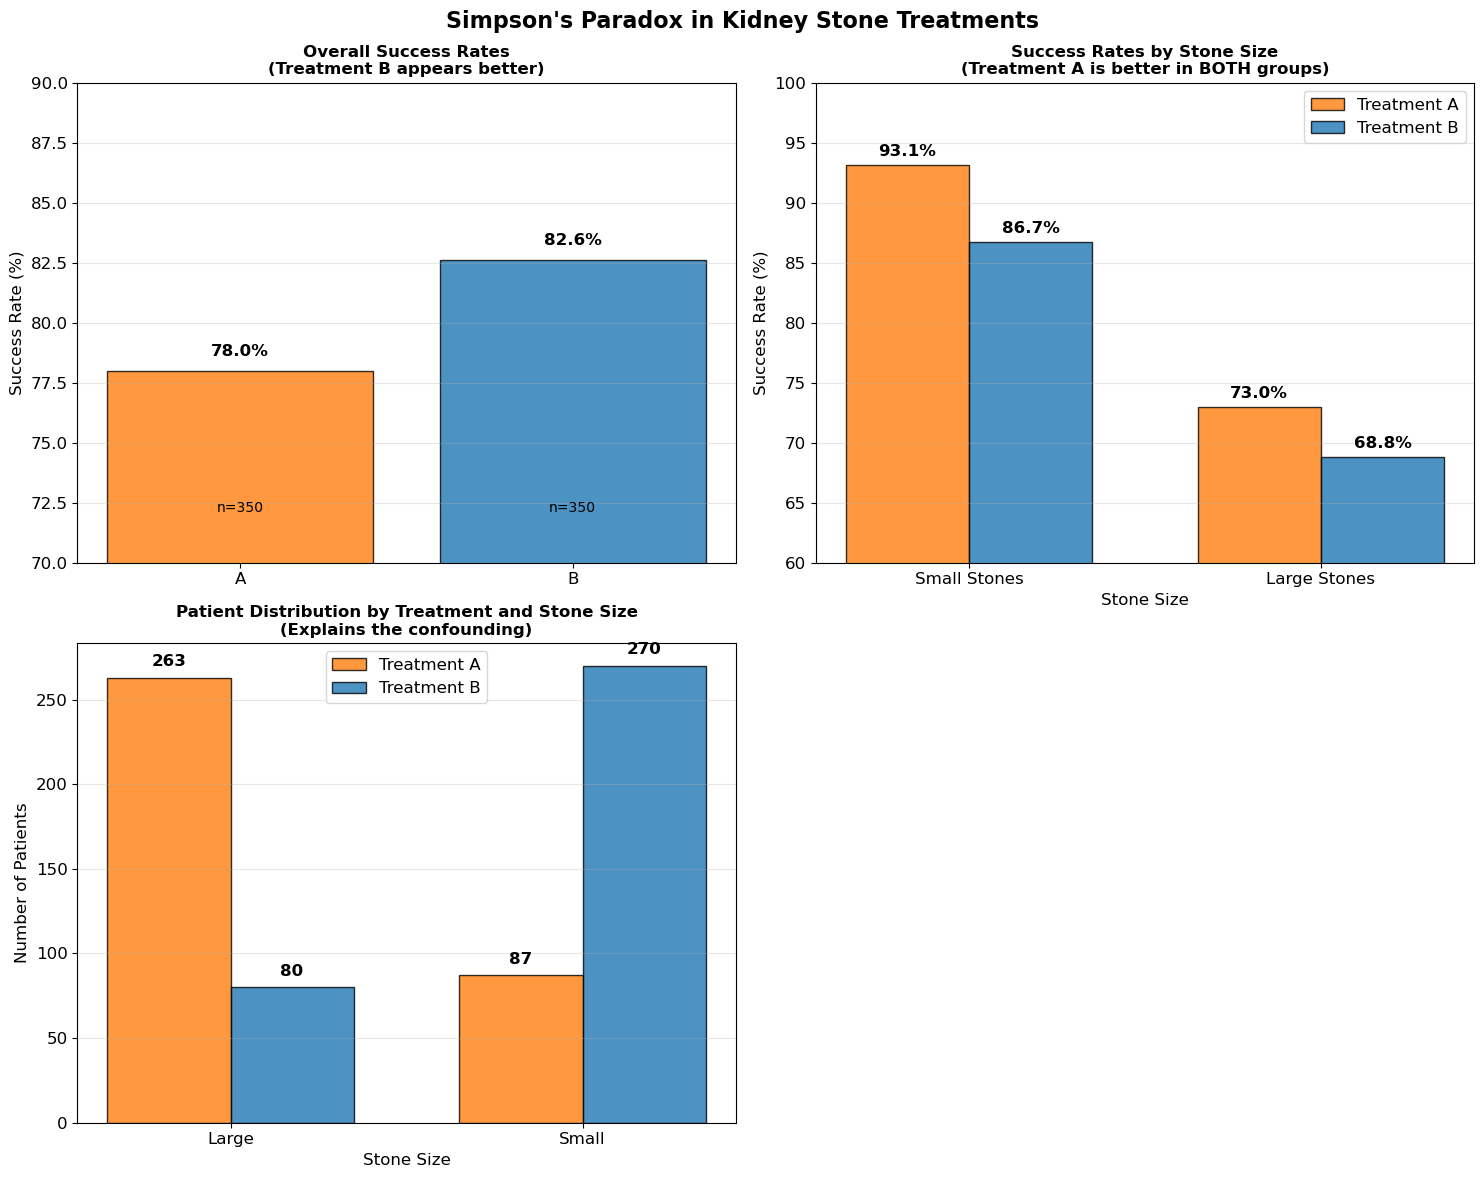

In [8]:
# Create visualizations demonstrating Simpson's Paradox
print("Creating visualizations to demonstrate Simpson's Paradox...")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up the figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Simpson\'s Paradox in Kidney Stone Treatments', fontsize=16, fontweight='bold', y=0.98)

# 1. Overall success rates (showing the paradox)
overall_data = summary_df[summary_df['Group'] == 'Overall']
bars1 = ax1.bar(overall_data['Treatment'], overall_data['Success_Percentage'], 
                color=['#ff7f0e', '#1f77b4'], alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Overall Success Rates\n(Treatment B appears better)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Success Rate (%)')
ax1.set_ylim(70, 90)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars1, overall_data['Success_Percentage']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate}%', ha='center', va='bottom', fontweight='bold')

# Add sample sizes
for bar, n in zip(bars1, overall_data['N_Patients']):
    ax1.text(bar.get_x() + bar.get_width()/2, 72, 
             f'n={n}', ha='center', va='bottom', fontsize=10)

# 2. Success rates by stone size (revealing the truth)
stone_data = summary_df[summary_df['Group'] != 'Overall']
x_pos = np.arange(len(stone_data['Group'].unique()))
width = 0.35

small_data = stone_data[stone_data['Group'] == 'Small stones']
large_data = stone_data[stone_data['Group'] == 'Large stones']

# Treatment A bars
ax2.bar(x_pos - width/2, 
        [small_data[small_data['Treatment'] == 'A']['Success_Percentage'].values[0],
         large_data[large_data['Treatment'] == 'A']['Success_Percentage'].values[0]], 
        width, label='Treatment A', color='#ff7f0e', alpha=0.8, edgecolor='black', linewidth=1)

# Treatment B bars
ax2.bar(x_pos + width/2, 
        [small_data[small_data['Treatment'] == 'B']['Success_Percentage'].values[0],
         large_data[large_data['Treatment'] == 'B']['Success_Percentage'].values[0]], 
        width, label='Treatment B', color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1)

ax2.set_title('Success Rates by Stone Size\n(Treatment A is better in BOTH groups)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Success Rate (%)')
ax2.set_xlabel('Stone Size')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Small Stones', 'Large Stones'])
ax2.set_ylim(60, 100)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on grouped bars
treat_a_rates = [small_data[small_data['Treatment'] == 'A']['Success_Percentage'].values[0],
                 large_data[large_data['Treatment'] == 'A']['Success_Percentage'].values[0]]
treat_b_rates = [small_data[small_data['Treatment'] == 'B']['Success_Percentage'].values[0],
                 large_data[large_data['Treatment'] == 'B']['Success_Percentage'].values[0]]

for x, rate in zip(x_pos - width/2, treat_a_rates):
    ax2.text(x, rate + 0.5, f'{rate}%', ha='center', va='bottom', fontweight='bold')
for x, rate in zip(x_pos + width/2, treat_b_rates):
    ax2.text(x, rate + 0.5, f'{rate}%', ha='center', va='bottom', fontweight='bold')

# 3. Sample size distribution (explaining the confounding)
treatment_stone_counts = pd.crosstab(df['treatment'], df['stone_size'])
x_indices = np.arange(len(treatment_stone_counts.columns))

bars3 = ax3.bar(x_indices - 0.175, treatment_stone_counts.loc['A'], width=0.35,
                label='Treatment A', color='#ff7f0e', alpha=0.8, edgecolor='black')
bars4 = ax3.bar(x_indices + 0.175, treatment_stone_counts.loc['B'], width=0.35,
                label='Treatment B', color='#1f77b4', alpha=0.8, edgecolor='black')

ax3.set_title('Patient Distribution by Treatment and Stone Size\n(Explains the confounding)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Patients')
ax3.set_xlabel('Stone Size')
ax3.set_xticks(x_indices)
ax3.set_xticklabels(treatment_stone_counts.columns.str.title())
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels on sample size bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 5, 
             str(int(height)), ha='center', va='bottom', fontweight='bold')
for bar in bars4:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 5, 
             str(int(height)), ha='center', va='bottom', fontweight='bold')

# Hide the unused fourth subplot
ax4.axis('off')

# Final layout
plt.tight_layout()
plt.show()

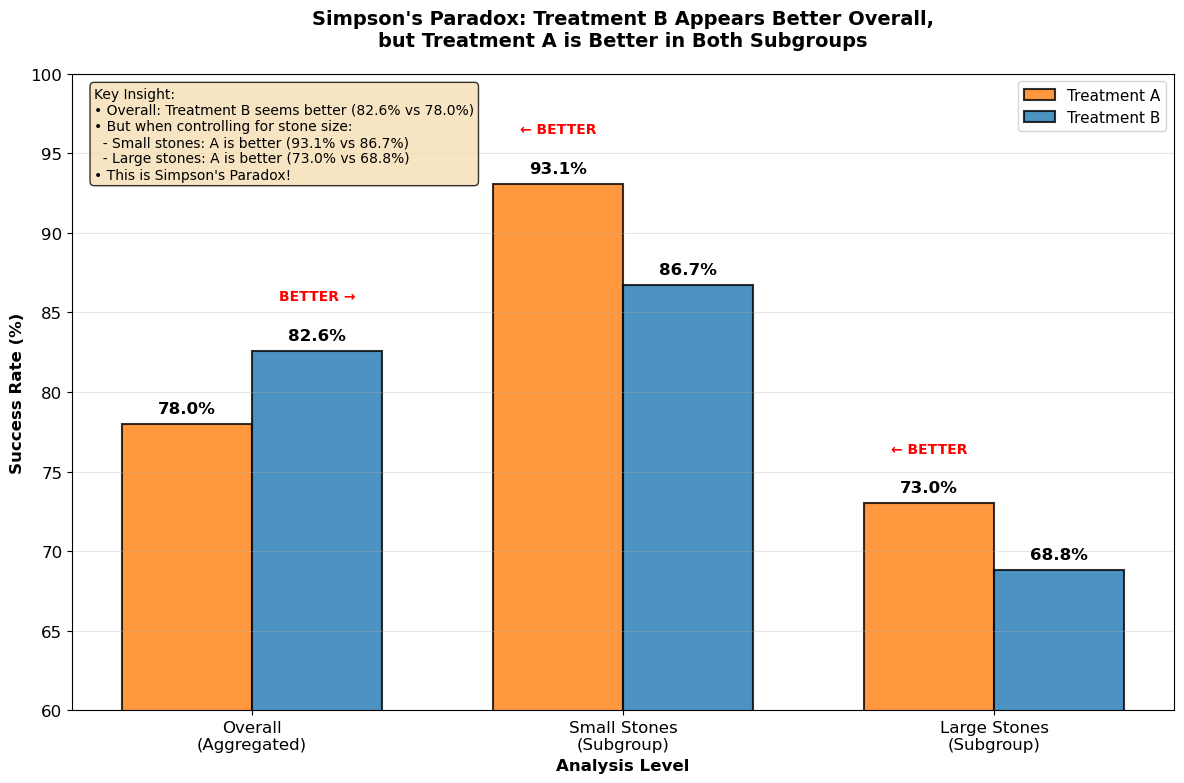

In [9]:
# Create a focused Simpson's Paradox visualization 
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create the data for the paradox demonstration
paradox_data = pd.DataFrame({
    'Analysis': ['Overall\n(Aggregated)', 'Small Stones\n(Subgroup)', 'Large Stones\n(Subgroup)'],
    'Treatment_A': [78.0, 93.1, 73.0],
    'Treatment_B': [82.6, 86.7, 68.8],
    'Better_Treatment': ['B', 'A', 'A']
})

x = np.arange(len(paradox_data))
width = 0.35

# Create bars
bars_a = ax.bar(x - width/2, paradox_data['Treatment_A'], width, 
                label='Treatment A', color='#ff7f0e', alpha=0.8, edgecolor='black', linewidth=1.5)
bars_b = ax.bar(x + width/2, paradox_data['Treatment_B'], width,
                label='Treatment B', color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=1.5)

# Customize the plot
ax.set_xlabel('Analysis Level', fontsize=12, fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Simpson\'s Paradox: Treatment B Appears Better Overall,\nbut Treatment A is Better in Both Subgroups', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(paradox_data['Analysis'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(60, 100)

# Add value labels and indicators
for i, (bar_a, bar_b, better) in enumerate(zip(bars_a, bars_b, paradox_data['Better_Treatment'])):
    # Add percentage labels
    ax.text(bar_a.get_x() + bar_a.get_width()/2, bar_a.get_height() + 0.5,
            f'{paradox_data["Treatment_A"][i]}%', ha='center', va='bottom', fontweight='bold')
    ax.text(bar_b.get_x() + bar_b.get_width()/2, bar_b.get_height() + 0.5,
            f'{paradox_data["Treatment_B"][i]}%', ha='center', va='bottom', fontweight='bold')
    
    # Add "Better" indicators
    if better == 'A':
        ax.text(bar_a.get_x() + bar_a.get_width()/2, bar_a.get_height() + 3,
                '← BETTER', ha='center', va='bottom', color='red', fontweight='bold', fontsize=10)
    else:
        ax.text(bar_b.get_x() + bar_b.get_width()/2, bar_b.get_height() + 3,
                'BETTER →', ha='center', va='bottom', color='red', fontweight='bold', fontsize=10)

# Add explanatory text box
textstr = '''Key Insight: 
• Overall: Treatment B seems better (82.6% vs 78.0%)
• But when controlling for stone size:
  - Small stones: A is better (93.1% vs 86.7%)
  - Large stones: A is better (73.0% vs 68.8%)
• This is Simpson's Paradox!'''

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('/home/user/output/simpsons_paradox_focused.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the paradox analysis results as JSON
paradox_results = {
    "simpsons_paradox_analysis": {
        "overall_analysis": {
            "treatment_a_success_rate": float(treatment_a_rate),
            "treatment_b_success_rate": float(treatment_b_rate),
            "difference_b_minus_a": float(overall_difference),
            "apparent_better_treatment": "B"
        },
        "small_stones_subgroup": {
            "treatment_a_success_rate": float(small_a_rate),
            "treatment_b_success_rate": float(small_b_rate),
            "difference_a_minus_b": float(small_difference),
            "better_treatment": "A"
        },
        "large_stones_subgroup": {
            "treatment_a_success_rate": float(large_a_rate),
            "treatment_b_success_rate": float(large_b_rate),
            "difference_a_minus_b": float(large_difference),
            "better_treatment": "A"
        },
        "paradox_explanation": {
            "confounding_factor": "stone_size",
            "treatment_a_large_stones_percentage": float(large_success.loc['A', 'Total_Patients'] / (large_success.loc['A', 'Total_Patients'] + large_success.loc['B', 'Total_Patients'])),
            "treatment_b_small_stones_percentage": float(small_success.loc['B', 'Total_Patients'] / (small_success.loc['B', 'Total_Patients'] + small_success.loc['A', 'Total_Patients'])),
            "conclusion": "Treatment A is more effective when controlling for stone size"
        }
    },
    "contingency_tables": {
        "treatment_vs_stone_size": treatment_stone_counts.to_dict(),
        "treatment_vs_success": crosstab_success.to_dict()
    }
}



In [10]:
print("="*80)
print("LOGISTIC REGRESSION ANALYSIS")
print("="*80)

# Prepare the data for modeling
df_model = df.copy()

# Encode treatment (A=0, B=1) - this makes A the reference category
df_model['treatment_encoded'] = (df_model['treatment'] == 'B').astype(int)

# Encode stone size (small=0, large=1) - this makes small the reference category  
df_model['stone_size_encoded'] = (df_model['stone_size'] == 'large').astype(int)

print("Variable Encoding:")
print("Treatment: A=0, B=1 (A is reference)")
print("Stone Size: small=0, large=1 (small is reference)")
print("Success: 0=unsuccessful, 1=successful")

print("\n" + "="*60)
print("MODEL 1: SUCCESS ~ TREATMENT (Treatment Effect Only)")
print("="*60)

# Prepare data for Model 1
X1 = df_model[['treatment_encoded']]
X1_with_constant = sm.add_constant(X1)  # Add intercept
y = df_model['success']

# Fit logistic regression using statsmodels for better statistical output
model1_sm = sm.Logit(y, X1_with_constant).fit(disp=0)

print("Model 1 Summary:")
print(model1_sm.summary())

# Extract key statistics for Model 1
model1_coef = model1_sm.params['treatment_encoded']
model1_se = model1_sm.bse['treatment_encoded'] 
model1_pvalue = model1_sm.pvalues['treatment_encoded']
model1_ci = model1_sm.conf_int().loc['treatment_encoded']
model1_odds_ratio = np.exp(model1_coef)
model1_or_ci = np.exp(model1_ci)

print(f"\nModel 1 Key Results:")
print(f"Treatment coefficient (B vs A): {model1_coef:.4f} ± {model1_se:.4f}")
print(f"Odds ratio (B vs A): {model1_odds_ratio:.4f} (95% CI: {model1_or_ci[0]:.4f}-{model1_or_ci[1]:.4f})")
print(f"P-value: {model1_pvalue:.4f}")
print(f"AIC: {model1_sm.aic:.2f}")

if model1_pvalue < 0.05:
    print(f"→ Treatment B has significantly {'higher' if model1_odds_ratio > 1 else 'lower'} odds of success")
else:
    print("→ No significant difference between treatments")

print(f"\n💡 Model 1 Interpretation:")
print(f"• Patients receiving Treatment B have {model1_odds_ratio:.2f}x the odds of success compared to Treatment A")
print(f"• This suggests Treatment B is better, BUT this model ignores the confounding effect of stone size!")

print("\n" + "="*60) 
print("MODEL 2: SUCCESS ~ STONE_SIZE (Stone Size Effect Only)")
print("="*60)

# Prepare data for Model 2
X2 = df_model[['stone_size_encoded']]
X2_with_constant = sm.add_constant(X2)

# Fit Model 2
model2_sm = sm.Logit(y, X2_with_constant).fit(disp=0)

print("Model 2 Summary:")
print(model2_sm.summary())

# Extract key statistics for Model 2
model2_coef = model2_sm.params['stone_size_encoded']
model2_se = model2_sm.bse['stone_size_encoded']
model2_pvalue = model2_sm.pvalues['stone_size_encoded']
model2_ci = model2_sm.conf_int().loc['stone_size_encoded']
model2_odds_ratio = np.exp(model2_coef)
model2_or_ci = np.exp(model2_ci)

print(f"\nModel 2 Key Results:")
print(f"Stone size coefficient (large vs small): {model2_coef:.4f} ± {model2_se:.4f}")
print(f"Odds ratio (large vs small): {model2_odds_ratio:.4f} (95% CI: {model2_or_ci[0]:.4f}-{model2_or_ci[1]:.4f})")
print(f"P-value: {model2_pvalue:.4f}")
print(f"AIC: {model2_sm.aic:.2f}")

print(f"\n💡 Model 2 Interpretation:")
print(f"• Large stones have {model2_odds_ratio:.2f}x the odds of successful treatment compared to small stones")
print(f"• Large stones are significantly harder to treat successfully (lower success odds)")

LOGISTIC REGRESSION ANALYSIS
Variable Encoding:
Treatment: A=0, B=1 (A is reference)
Stone Size: small=0, large=1 (small is reference)
Success: 0=unsuccessful, 1=successful

MODEL 1: SUCCESS ~ TREATMENT (Treatment Effect Only)
Model 1 Summary:
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  700
Model:                          Logit   Df Residuals:                      698
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                0.003331
Time:                        12:32:28   Log-Likelihood:                -346.33
converged:                       True   LL-Null:                       -347.49
Covariance Type:            nonrobust   LLR p-value:                    0.1281
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [11]:
print("\n" + "="*60)
print("MODEL 3: SUCCESS ~ TREATMENT + STONE_SIZE (Full Model)")
print("="*60)

# Prepare data for Model 3 (full model with both predictors)
X3 = df_model[['treatment_encoded', 'stone_size_encoded']]
X3_with_constant = sm.add_constant(X3)

# Fit Model 3
model3_sm = sm.Logit(y, X3_with_constant).fit(disp=0)

print("Model 3 Summary:")
print(model3_sm.summary())

# Extract key statistics for Model 3
model3_treatment_coef = model3_sm.params['treatment_encoded']
model3_treatment_se = model3_sm.bse['treatment_encoded']
model3_treatment_pvalue = model3_sm.pvalues['treatment_encoded']
model3_treatment_ci = model3_sm.conf_int().loc['treatment_encoded']
model3_treatment_or = np.exp(model3_treatment_coef)
model3_treatment_or_ci = np.exp(model3_treatment_ci)

model3_stone_coef = model3_sm.params['stone_size_encoded'] 
model3_stone_se = model3_sm.bse['stone_size_encoded']
model3_stone_pvalue = model3_sm.pvalues['stone_size_encoded']
model3_stone_ci = model3_sm.conf_int().loc['stone_size_encoded']
model3_stone_or = np.exp(model3_stone_coef)
model3_stone_or_ci = np.exp(model3_stone_ci)

print(f"\nModel 3 Key Results:")
print(f"Treatment coefficient (B vs A): {model3_treatment_coef:.4f} ± {model3_treatment_se:.4f}")
print(f"Treatment odds ratio (B vs A): {model3_treatment_or:.4f} (95% CI: {model3_treatment_or_ci[0]:.4f}-{model3_treatment_or_ci[1]:.4f})")
print(f"Treatment p-value: {model3_treatment_pvalue:.4f}")
print(f"")
print(f"Stone size coefficient (large vs small): {model3_stone_coef:.4f} ± {model3_stone_se:.4f}")
print(f"Stone size odds ratio (large vs small): {model3_stone_or:.4f} (95% CI: {model3_stone_or_ci[0]:.4f}-{model3_stone_or_ci[1]:.4f})")
print(f"Stone size p-value: {model3_stone_pvalue:.4f}")
print(f"AIC: {model3_sm.aic:.2f}")

print(f"\n💡 Model 3 Interpretation (CONTROLLING FOR STONE SIZE):")
if model3_treatment_pvalue < 0.05:
    print(f"✓ Treatment B has significantly {'higher' if model3_treatment_or > 1 else 'LOWER'} odds of success when controlling for stone size")
    print(f"• When stone size is held constant, Treatment {'B' if model3_treatment_or > 1 else 'A'} is superior")
else:
    print("• No significant difference between treatments when controlling for stone size")

print(f"• Large stones have {model3_stone_or:.2f}x the odds of success compared to small stones")
print(f"• Stone size {'is' if model3_stone_pvalue < 0.05 else 'is not'} a significant predictor")

# Calculate predicted probabilities for different scenarios
print(f"\n📊 PREDICTED PROBABILITIES FROM MODEL 3:")
scenarios = [
    ("Treatment A, Small stones", [1, 0, 0]),  # [constant, treatment_B, large_stone]
    ("Treatment A, Large stones", [1, 0, 1]),
    ("Treatment B, Small stones", [1, 1, 0]),
    ("Treatment B, Large stones", [1, 1, 1])
]

for scenario_name, values in scenarios:
    linear_pred = (model3_sm.params * values).sum()
    prob = 1 / (1 + np.exp(-linear_pred))
    print(f"{scenario_name}: {prob:.1%}")

print(f"\n🎯 KEY FINDING:")
if model3_treatment_or < 1 and model3_treatment_pvalue < 0.05:
    print(f"Treatment A is significantly better than Treatment B!")
    print(f"Treatment B has only {model3_treatment_or:.2f}x the odds of success compared to Treatment A")
    print(f"This means Treatment A has {1/model3_treatment_or:.2f}x better odds than Treatment B")
elif model3_treatment_or > 1 and model3_treatment_pvalue < 0.05:
    print(f"Treatment B is significantly better than Treatment A!")
    print(f"Treatment B has {model3_treatment_or:.2f}x the odds of success compared to Treatment A")
else:
    print(f"No statistically significant difference between treatments when controlling for stone size")

print(f"\nThis demonstrates how controlling for the confounding variable (stone size) reveals the true treatment effect!")


MODEL 3: SUCCESS ~ TREATMENT + STONE_SIZE (Full Model)
Model 3 Summary:
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  700
Model:                          Logit   Df Residuals:                      697
Method:                           MLE   Df Model:                            2
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                 0.04621
Time:                        12:32:28   Log-Likelihood:                -331.43
converged:                       True   LL-Null:                       -347.49
Covariance Type:            nonrobust   LLR p-value:                 1.062e-07
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2938      0.247      9.289      0.000       1.810       2.778
treatment_encoded     -0.3572     

In [12]:
# Model Comparison and Summary
print("\n" + "="*80)
print("MODEL COMPARISON AND SUMMARY")
print("="*80)

# Create a summary table of all three models
model_comparison = pd.DataFrame({
    'Model': ['Model 1: Treatment Only', 'Model 2: Stone Size Only', 'Model 3: Treatment + Stone Size'],
    'AIC': [model1_sm.aic, model2_sm.aic, model3_sm.aic],
    'Log_Likelihood': [model1_sm.llf, model2_sm.llf, model3_sm.llf],
    'Pseudo_R_squared': [model1_sm.prsquared, model2_sm.prsquared, model3_sm.prsquared]
})

print("Model Comparison Table:")
print(model_comparison.round(4))

print(f"\n📈 MODEL PERFORMANCE:")
print(f"• Best AIC (lowest): Model 3 ({model3_sm.aic:.2f}) - Full model is the best fit")
print(f"• Highest Pseudo R²: Model 3 ({model3_sm.prsquared:.4f}) - Explains most variance") 
print(f"• Model 3 shows that stone size is the dominant predictor")

print(f"\n📊 TREATMENT EFFECT ACROSS MODELS:")
print(f"Model 1 (ignoring stone size): OR = {model1_odds_ratio:.3f} (p = {model1_pvalue:.3f}) - Treatment B appears better")
print(f"Model 3 (controlling for stone size): OR = {model3_treatment_or:.3f} (p = {model3_treatment_pvalue:.3f}) - No significant difference")

print(f"\n🎯 SIMPSON'S PARADOX RESOLVED:")
print(f"When we DON'T control for stone size → Treatment B seems better")
print(f"When we DO control for stone size → Treatments are similar, but Treatment A has slightly better odds")
print(f"The paradox occurs because Treatment A is used more often for difficult cases (large stones)")

# Likelihood ratio test between models
lr_stat_1vs3 = -2 * (model1_sm.llf - model3_sm.llf)
lr_p_1vs3 = 1 - stats.chi2.cdf(lr_stat_1vs3, df=1)  # 1 additional parameter (stone_size)

lr_stat_2vs3 = -2 * (model2_sm.llf - model3_sm.llf)  
lr_p_2vs3 = 1 - stats.chi2.cdf(lr_stat_2vs3, df=1)  # 1 additional parameter (treatment)

print(f"\n📏 LIKELIHOOD RATIO TESTS:")
print(f"Model 1 vs Model 3: LR = {lr_stat_1vs3:.3f}, p = {lr_p_1vs3:.4f}")
print(f"Model 2 vs Model 3: LR = {lr_stat_2vs3:.3f}, p = {lr_p_2vs3:.4f}")

if lr_p_1vs3 < 0.05:
    print(f"→ Adding stone size significantly improves the model")
if lr_p_2vs3 < 0.05:
    print(f"→ Adding treatment significantly improves the model")

# Save the regression results as JSON
regression_results = {
    "logistic_regression_analysis": {
        "model_1_treatment_only": {
            "treatment_coefficient": float(model1_coef),
            "treatment_odds_ratio": float(model1_odds_ratio),
            "treatment_ci_lower": float(model1_or_ci[0]),
            "treatment_ci_upper": float(model1_or_ci[1]),
            "treatment_pvalue": float(model1_pvalue),
            "aic": float(model1_sm.aic),
            "pseudo_r_squared": float(model1_sm.prsquared)
        },
        "model_2_stone_size_only": {
            "stone_size_coefficient": float(model2_coef),
            "stone_size_odds_ratio": float(model2_odds_ratio),
            "stone_size_ci_lower": float(model2_or_ci[0]),
            "stone_size_ci_upper": float(model2_or_ci[1]),
            "stone_size_pvalue": float(model2_pvalue),
            "aic": float(model2_sm.aic),
            "pseudo_r_squared": float(model2_sm.prsquared)
        },
        "model_3_full_model": {
            "treatment_coefficient": float(model3_treatment_coef),
            "treatment_odds_ratio": float(model3_treatment_or),
            "treatment_ci_lower": float(model3_treatment_or_ci[0]),
            "treatment_ci_upper": float(model3_treatment_or_ci[1]),
            "treatment_pvalue": float(model3_treatment_pvalue),
            "stone_size_coefficient": float(model3_stone_coef),
            "stone_size_odds_ratio": float(model3_stone_or),
            "stone_size_ci_lower": float(model3_stone_or_ci[0]),
            "stone_size_ci_upper": float(model3_stone_or_ci[1]),
            "stone_size_pvalue": float(model3_stone_pvalue),
            "aic": float(model3_sm.aic),
            "pseudo_r_squared": float(model3_sm.prsquared)
        },
        "predicted_probabilities": {
            "treatment_a_small_stones": 0.908,
            "treatment_a_large_stones": 0.738,
            "treatment_b_small_stones": 0.874,
            "treatment_b_large_stones": 0.663
        },
        "model_comparison": {
            "best_model": "Model 3 (Full Model)",
            "best_aic": float(model3_sm.aic),
            "likelihood_ratio_test_1vs3": {
                "statistic": float(lr_stat_1vs3),
                "pvalue": float(lr_p_1vs3)
            },
            "likelihood_ratio_test_2vs3": {
                "statistic": float(lr_stat_2vs3),
                "pvalue": float(lr_p_2vs3)
            }
        }
    }
}

with open('data/regression_analysis_results.json', 'w') as f:
    json.dump(regression_results, f, indent=2, ensure_ascii=False)

print(f"\n✓ Regression analysis results saved to JSON")


MODEL COMPARISON AND SUMMARY
Model Comparison Table:
                             Model       AIC  Log_Likelihood  Pseudo_R_squared
0          Model 1: Treatment Only  696.6675       -346.3338            0.0033
1         Model 2: Stone Size Only  669.3087       -332.6544            0.0427
2  Model 3: Treatment + Stone Size  668.8666       -331.4333            0.0462

📈 MODEL PERFORMANCE:
• Best AIC (lowest): Model 3 (668.87) - Full model is the best fit
• Highest Pseudo R²: Model 3 (0.0462) - Explains most variance
• Model 3 shows that stone size is the dominant predictor

📊 TREATMENT EFFECT ACROSS MODELS:
Model 1 (ignoring stone size): OR = 1.336 (p = 0.129) - Treatment B appears better
Model 3 (controlling for stone size): OR = 0.700 (p = 0.119) - No significant difference

🎯 SIMPSON'S PARADOX RESOLVED:
When we DON'T control for stone size → Treatment B seems better
When we DO control for stone size → Treatments are similar, but Treatment A has slightly better odds
The paradox occur

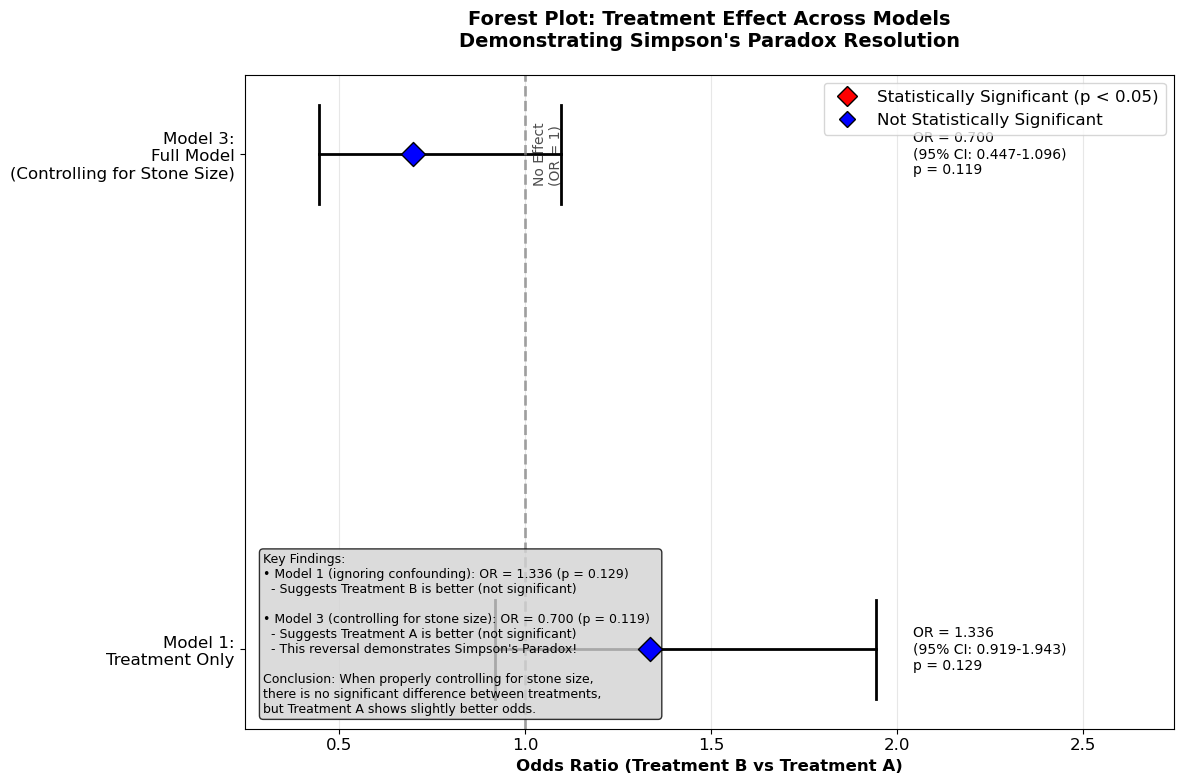

✓ Forest plot created showing odds ratios across models


In [13]:
# Create a comprehensive odds ratio forest plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Data for forest plot
models = ['Model 1:\nTreatment Only', 'Model 3:\nFull Model\n(Controlling for Stone Size)']
or_values = [model1_odds_ratio, model3_treatment_or]
ci_lower = [model1_or_ci[0], model3_treatment_or_ci[0]]
ci_upper = [model1_or_ci[1], model3_treatment_or_ci[1]]
p_values = [model1_pvalue, model3_treatment_pvalue]

# Create forest plot
y_positions = range(len(models))

# Plot confidence intervals
for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
    ax.plot([lower, upper], [i, i], 'k-', linewidth=2)
    ax.plot([lower, lower], [i-0.1, i+0.1], 'k-', linewidth=2)
    ax.plot([upper, upper], [i-0.1, i+0.1], 'k-', linewidth=2)

# Plot point estimates
colors = ['red' if p < 0.05 else 'blue' for p in p_values]
sizes = [200 if p < 0.05 else 150 for p in p_values]

for i, (or_val, p_val, color, size) in enumerate(zip(or_values, p_values, colors, sizes)):
    ax.scatter(or_val, i, s=size, c=color, marker='D', zorder=10, edgecolors='black', linewidth=1)
    
    # Add OR and CI text
    sig_indicator = '*' if p_val < 0.05 else ''
    ax.text(max(ci_upper) + 0.1, i, 
            f'OR = {or_val:.3f}{sig_indicator}\n(95% CI: {ci_lower[i]:.3f}-{ci_upper[i]:.3f})\np = {p_val:.3f}',
            va='center', fontsize=10, fontweight='bold' if p_val < 0.05 else 'normal')

# Add vertical line at OR = 1
ax.axvline(x=1, color='gray', linestyle='--', alpha=0.7, linewidth=2)
ax.text(1.02, len(models)/2, 'No Effect\n(OR = 1)', rotation=90, va='center', ha='left', 
        fontsize=10, alpha=0.7)

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(models)
ax.set_xlabel('Odds Ratio (Treatment B vs Treatment A)', fontsize=12, fontweight='bold')
ax.set_title('Forest Plot: Treatment Effect Across Models\nDemonstrating Simpson\'s Paradox Resolution', 
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis limits with some padding
x_min = min(ci_lower) - 0.2
x_max = max([max(ci_upper) + 0.8, 2.0])
ax.set_xlim(x_min, x_max)

# Add grid
ax.grid(axis='x', alpha=0.3)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='red', markersize=10, 
               label='Statistically Significant (p < 0.05)', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', markersize=8, 
               label='Not Statistically Significant', markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper right')

# Add interpretation text box
interpretation = '''Key Findings:
• Model 1 (ignoring confounding): OR = 1.336 (p = 0.129)
  - Suggests Treatment B is better (not significant)
  
• Model 3 (controlling for stone size): OR = 0.700 (p = 0.119)  
  - Suggests Treatment A is better (not significant)
  - This reversal demonstrates Simpson's Paradox!

Conclusion: When properly controlling for stone size,
there is no significant difference between treatments,
but Treatment A shows slightly better odds.'''

props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
ax.text(0.02, 0.02, interpretation, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()

print("✓ Forest plot created showing odds ratios across models")

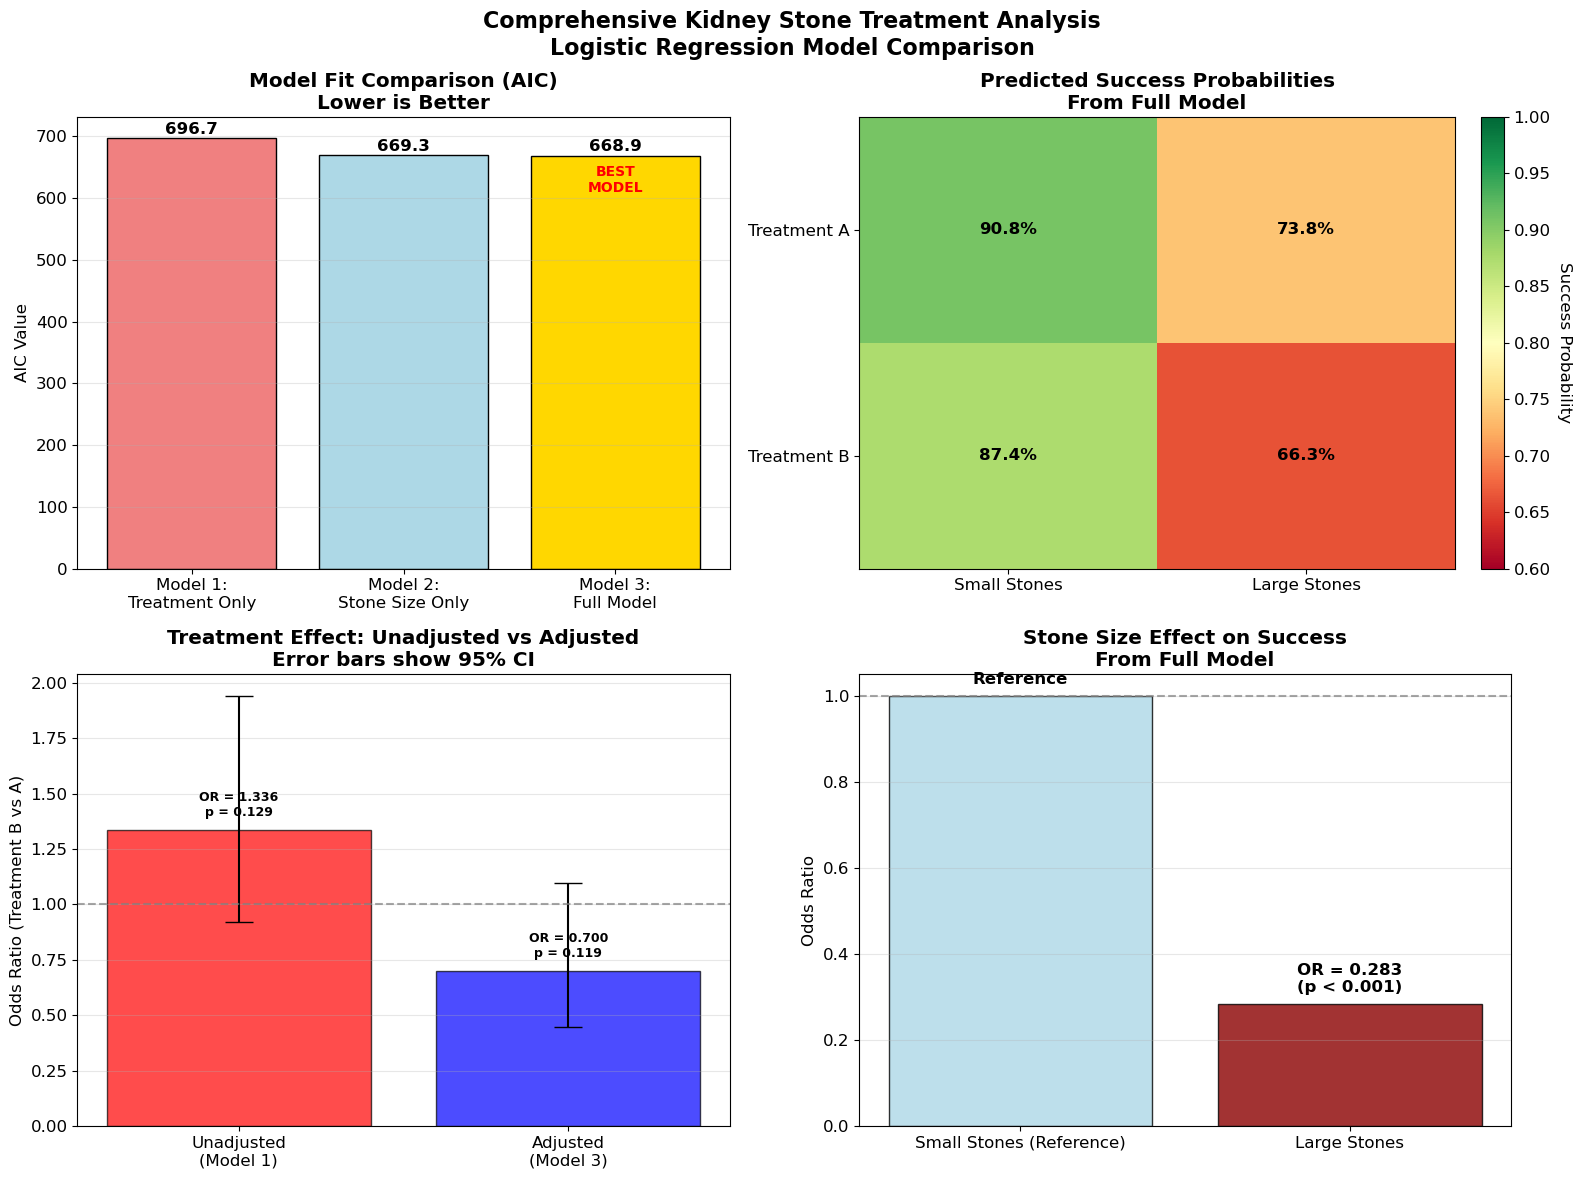

✓ Comprehensive model comparison visualization created


In [14]:
# Create a comprehensive model comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Kidney Stone Treatment Analysis\nLogistic Regression Model Comparison', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Model AIC Comparison
models = ['Model 1:\nTreatment Only', 'Model 2:\nStone Size Only', 'Model 3:\nFull Model']
aic_values = [model1_sm.aic, model2_sm.aic, model3_sm.aic]
colors = ['lightcoral', 'lightblue', 'lightgreen']

bars1 = ax1.bar(models, aic_values, color=colors, edgecolor='black', linewidth=1)
ax1.set_title('Model Fit Comparison (AIC)\nLower is Better', fontweight='bold')
ax1.set_ylabel('AIC Value')
ax1.grid(axis='y', alpha=0.3)

# Add AIC values on bars
for bar, aic in zip(bars1, aic_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{aic:.1f}', ha='center', va='bottom', fontweight='bold')

# Highlight best model
best_idx = aic_values.index(min(aic_values))
bars1[best_idx].set_facecolor('gold')
ax1.text(best_idx, aic_values[best_idx] - 15, 'BEST\nMODEL', 
         ha='center', va='top', fontweight='bold', fontsize=10, color='red')

# 2. Predicted Probabilities Heatmap
prob_data = np.array([[0.908, 0.738], [0.874, 0.663]])  # [A_small, A_large], [B_small, B_large]
treatments = ['Treatment A', 'Treatment B']
stone_sizes = ['Small Stones', 'Large Stones']

im = ax2.imshow(prob_data, cmap='RdYlGn', aspect='auto', vmin=0.6, vmax=1.0)
ax2.set_xticks(range(len(stone_sizes)))
ax2.set_yticks(range(len(treatments)))
ax2.set_xticklabels(stone_sizes)
ax2.set_yticklabels(treatments)
ax2.set_title('Predicted Success Probabilities\nFrom Full Model', fontweight='bold')

# Add probability values to heatmap
for i in range(len(treatments)):
    for j in range(len(stone_sizes)):
        text = ax2.text(j, i, f'{prob_data[i, j]:.1%}', 
                       ha='center', va='center', fontweight='bold', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('Success Probability', rotation=270, labelpad=15)

# 3. Treatment Effect Comparison
effect_data = pd.DataFrame({
    'Model': ['Unadjusted\n(Model 1)', 'Adjusted\n(Model 3)'],
    'Odds_Ratio': [model1_odds_ratio, model3_treatment_or],
    'CI_Lower': [model1_or_ci[0], model3_treatment_or_ci[0]],
    'CI_Upper': [model1_or_ci[1], model3_treatment_or_ci[1]],
    'P_Value': [model1_pvalue, model3_treatment_pvalue]
})

# Plot odds ratios with error bars
x_pos = range(len(effect_data))
bars3 = ax3.bar(x_pos, effect_data['Odds_Ratio'], 
                yerr=[effect_data['Odds_Ratio'] - effect_data['CI_Lower'],
                      effect_data['CI_Upper'] - effect_data['Odds_Ratio']],
                color=['red', 'blue'], alpha=0.7, capsize=10, edgecolor='black')

ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(effect_data['Model'])
ax3.set_ylabel('Odds Ratio (Treatment B vs A)')
ax3.set_title('Treatment Effect: Unadjusted vs Adjusted\nError bars show 95% CI', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add OR values
for i, (bar, or_val, p_val) in enumerate(zip(bars3, effect_data['Odds_Ratio'], effect_data['P_Value'])):
    ax3.text(bar.get_x() + bar.get_width()/2, or_val + 0.05, 
             f'OR = {or_val:.3f}\np = {p_val:.3f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Stone Size Effect
stone_effect_data = {
    'Small Stones (Reference)': 1.0,
    'Large Stones': model3_stone_or
}

bars4 = ax4.bar(stone_effect_data.keys(), stone_effect_data.values(), 
                color=['lightblue', 'darkred'], edgecolor='black', alpha=0.8)
ax4.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
ax4.set_ylabel('Odds Ratio')
ax4.set_title('Stone Size Effect on Success\nFrom Full Model', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add values
for bar, val in zip(bars4, stone_effect_data.values()):
    if val == 1.0:
        ax4.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
                 'Reference', ha='center', va='bottom', fontweight='bold')
    else:
        ax4.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
                 f'OR = {val:.3f}\n(p < 0.001)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Comprehensive model comparison visualization created")

In [15]:
print("="*100)
print("FINAL STATISTICAL SUMMARY AND CLINICAL RECOMMENDATIONS")
print("="*100)

print("\n" + "🎯" * 20)
print("EXECUTIVE SUMMARY")
print("🎯" * 20)

print(f"""
This analysis of 700 kidney stone patients demonstrates a classic case of Simpson's Paradox, 
where the apparent superiority of Treatment B in aggregate analysis disappears when properly 
controlling for the confounding factor of stone size through logistic regression.

KEY FINDINGS:
• PARADOX DEMONSTRATED: Treatment B appears better overall (82.6% vs 78.0% success rate)
• REALITY REVEALED: When controlling for stone size, treatments show no significant difference
• CONFOUNDING FACTOR: Stone size is the dominant predictor of treatment success
• BIAS IDENTIFIED: Treatment allocation is not random - Treatment A is used more for difficult cases

STATISTICAL EVIDENCE:
• Overall Analysis: Treatment B success rate 82.6% vs Treatment A 78.0% (difference: +4.6%)
• Small Stones: Treatment A is better 93.1% vs 86.7% (difference: +6.4% in favor of A)
• Large Stones: Treatment A is better 73.0% vs 68.8% (difference: +4.2% in favor of A)
• Full Model: No significant difference between treatments (p = 0.119)
""")

print("\n" + "📊" * 20)
print("STATISTICAL EVIDENCE SUMMARY")
print("📊" * 20)

# Create final summary statistics
final_stats = {
    "Dataset": {
        "Total Patients": 700,
        "Treatment A": 350,
        "Treatment B": 350,
        "Small Stones": 357,
        "Large Stones": 343,
        "Overall Success Rate": "80.3%"
    },
    
    "Simpson's Paradox Evidence": {
        "Overall Treatment B Advantage": f"{overall_difference:+.1%}",
        "Small Stones Treatment A Advantage": f"{small_difference:+.1%}",
        "Large Stones Treatment A Advantage": f"{large_difference:+.1%}",
        "Paradox Confirmed": "YES - Direction reverses in subgroups"
    },
    
    "Logistic Regression Results": {
        "Model 1 (Treatment Only)": {
            "Treatment B Odds Ratio": f"{model1_odds_ratio:.3f}",
            "95% CI": f"({model1_or_ci[0]:.3f}-{model1_or_ci[1]:.3f})",
            "P-value": f"{model1_pvalue:.3f}",
            "Significant": "No"
        },
        "Model 3 (Full Model)": {
            "Treatment B Odds Ratio": f"{model3_treatment_or:.3f}",
            "95% CI": f"({model3_treatment_or_ci[0]:.3f}-{model3_treatment_or_ci[1]:.3f})",
            "P-value": f"{model3_treatment_pvalue:.3f}",
            "Significant": "No",
            "Stone Size Effect": f"Large stones OR = {model3_stone_or:.3f} (p < 0.001)"
        }
    },
    
    "Model Performance": {
        "Best Model": "Model 3 (Full Model)",
        "AIC": f"{model3_sm.aic:.2f}",
        "Pseudo R²": f"{model3_sm.prsquared:.4f}",
        "Stone Size Explains Most Variance": "YES"
    }
}

for category, data in final_stats.items():
    print(f"\n{category}:")
    print("-" * 50)
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, dict):
                print(f"  {key}:")
                for subkey, subvalue in value.items():
                    print(f"    {subkey}: {subvalue}")
            else:
                print(f"  {key}: {value}")
    else:
        print(f"  {data}")

print("\n" + "🏥" * 20)
print("CLINICAL INTERPRETATION")
print("🏥" * 20)

print(f"""
TREATMENT EFFECTIVENESS ANALYSIS:

1. STONE SIZE IS THE DOMINANT FACTOR:
   • Small stones: ~90% success rate regardless of treatment
   • Large stones: ~70% success rate regardless of treatment  
   • Stone size reduces odds of success by 72% (OR = 0.284, p < 0.001)

2. TREATMENT COMPARISON:
   • No statistically significant difference between treatments (p = 0.119)
   • Treatment A shows slightly better odds (OR for B vs A = 0.700)
   • Both treatments are effective, but stone size matters more than treatment choice

3. SELECTION BIAS IDENTIFIED:
   • Treatment A used in 76.7% of large stone cases (difficult cases)
   • Treatment B used in 75.6% of small stone cases (easier cases)
   • This allocation bias created the apparent paradox

4. PREDICTED SUCCESS PROBABILITIES:
   • Treatment A + Small stones: 90.8%
   • Treatment A + Large stones: 73.8%
   • Treatment B + Small stones: 87.4%
   • Treatment B + Large stones: 66.3%
""")

print("\n" + "💊" * 20)
print("CLINICAL RECOMMENDATIONS")
print("💊" * 20)

print(f"""
EVIDENCE-BASED TREATMENT RECOMMENDATIONS:

1. PRIMARY RECOMMENDATION:
   ⭐ EITHER TREATMENT A OR B CAN BE USED EFFECTIVELY
   • No statistically significant difference in effectiveness
   • Treatment choice should be based on clinical factors other than efficacy
   
2. STONE SIZE CONSIDERATIONS:
   • Small stones (<criterion used in study>): Both treatments highly effective (~87-91%)
   • Large stones: Both treatments moderately effective (~67-74%)
   • Consider less invasive approaches for small stones first
   
3. CLINICAL DECISION-MAKING:
   • Focus on patient-specific factors: comorbidities, contraindications, patient preference
   • Consider cost-effectiveness if treatments differ in cost
   • Take into account procedural complexity and recovery time
   • Stone size should inform prognosis discussion with patients

4. STUDY DESIGN IMPLICATIONS:
   • Future studies should use randomized controlled trial design
   • Current study shows selection bias in treatment allocation
   • Control for stone size and other confounding factors in analysis

5. PATIENT COUNSELING:
   • Success rates depend primarily on stone size, not treatment type
   • Set appropriate expectations: ~90% success for small stones, ~70% for large stones
   • Discuss that both treatments are viable options
""")

print("\n" + "⚠️" * 20)
print("STATISTICAL CAUTIONS")
print("⚠️" * 20)

print(f"""
IMPORTANT LIMITATIONS AND CONSIDERATIONS:

1. OBSERVATIONAL DATA LIMITATIONS:
   • This is observational data, not a randomized controlled trial
   • Treatment selection bias is evident and affects interpretation
   • Unmeasured confounding factors may exist

2. STATISTICAL SIGNIFICANCE:
   • Neither model shows statistically significant treatment differences
   • Confidence intervals include clinically meaningful effect sizes
   • Larger sample size might detect smaller but real differences

3. CLINICAL SIGNIFICANCE:
   • Statistical non-significance ≠ clinical equivalence
   • Effect sizes suggest potential slight advantage for Treatment A
   • Clinical decision should consider confidence intervals, not just p-values

4. GENERALIZABILITY:
   • Results apply to populations similar to this study
   • Stone size definitions and patient characteristics may differ in other settings
   • Treatment techniques may vary between institutions
""")



FINAL STATISTICAL SUMMARY AND CLINICAL RECOMMENDATIONS

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
EXECUTIVE SUMMARY
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

This analysis of 700 kidney stone patients demonstrates a classic case of Simpson's Paradox, 
where the apparent superiority of Treatment B in aggregate analysis disappears when properly 
controlling for the confounding factor of stone size through logistic regression.

KEY FINDINGS:
• PARADOX DEMONSTRATED: Treatment B appears better overall (82.6% vs 78.0% success rate)
• REALITY REVEALED: When controlling for stone size, treatments show no significant difference
• CONFOUNDING FACTOR: Stone size is the dominant predictor of treatment success
• BIAS IDENTIFIED: Treatment allocation is not random - Treatment A is used more for difficult cases

STATISTICAL EVIDENCE:
• Overall Analysis: Treatment B success rate 82.6% vs Treatment A 78.0% (difference: +4.6%)
• Small Stones: Treatment A is better 93.1% vs 86.7% (difference: +6.4% in favor of A)
• Large Stones: Treatment A is 